In [43]:
# look at data visualizations to see which predictors clearly have a divide, and try removing those
# could try to remove as many predictors as possible while maintaining accuracy > 90%

# try different models (ensemble, etc.) from later in class for decision trees with predictor sub groups
# collapse rare values of predictors (maybe into an "Other" category)

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import make_scorer, recall_score,accuracy_score
from sklearn.metrics import precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import statsmodels.formula.api as sm
import itertools as it
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [45]:
#optimize recall = minimizing FNR + model accuracy (goal)

In [2]:
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
    pred_values = model.predict_proba(data)[:,1]
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    recall = 100 - fnr 
    print("Accuracy = ", accuracy)
    print("FNR = ", fnr)
    print("Precision = ", precision)
    print("Recall = ", recall)
    print("Confusion matrix = \n", cm_df)
    return (" ")
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
def plot_roc_curve(fpr, tpr, label = None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0, 1, 0.05), rotation = 90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

In [3]:
data = pd.read_csv("mushrooms.csv")
data

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [4]:
data.columns.tolist()

['class',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'bruises',
 'odor',
 'gill-attachment',
 'gill-spacing',
 'gill-size',
 'gill-color',
 'stalk-shape',
 'stalk-root',
 'stalk-surface-above-ring',
 'stalk-surface-below-ring',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'veil-type',
 'veil-color',
 'ring-number',
 'ring-type',
 'spore-print-color',
 'population',
 'habitat']

## Decision Tree with All Data
Strongly correlated predictors (based on data visualizations) removed

In [4]:
data = data.drop(columns=['odor','gill-attachment',
                          'veil-type','veil-color'])

In [5]:
#transform all predictors into dummy variables 
#1 == poisonious, 0 = edible 
X = pd.get_dummies(data, prefix_sep = '', 
                   columns = data.columns.drop('class')).drop(['class'], 
                                                              axis = 1)
y = np.where(data["class"] == "e", 0, 1)

In [47]:
#splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, 
                                                    random_state = 1)

In [48]:
#param grid to find max_depth and max_leaf_nodes that optimize recall 
param_grid = {'max_depth': range(5, 20),
              'max_leaf_nodes': range(10, 50)}
skf = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 1), param_grid, 
                           scoring = ['precision', 'accuracy', 'recall'], 
                           refit = "recall", 
                           cv = skf, n_jobs = -1, verbose = True)
grid_search.fit(X_train, y_train)
print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1508 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 2308 tasks      | elapsed:  2.4min


Best params for recall
{'max_depth': 10, 'max_leaf_nodes': 17}


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.6min finished


In [49]:
#fit model with optimized max_depth and max_leaf_nodes, max_depth = 10, max_leaf_nodes = 30
#model = DecisionTreeClassifier(random_state = 1, max_depth = 8, max_leaf_nodes = 15).fit(X_train, y_train)
model = DecisionTreeClassifier(random_state = 1, max_depth = 10, 
                               max_leaf_nodes = 17).fit(X, y)

In [50]:
print(confusion_matrix_data(X_train, y_train, model))

Accuracy =  100.0
FNR =  0.0
Precision =  100.0
Recall =  100.0
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       2843.0          0.0
Actual 1          0.0       2600.0
 


In [51]:
print(confusion_matrix_data(X_test, y_test, model))

Accuracy =  100.0
FNR =  0.0
Precision =  100.0
Recall =  100.0
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1365.0          0.0
Actual 1          0.0       1316.0
 


ROC-AUC: 0.7521919569791911


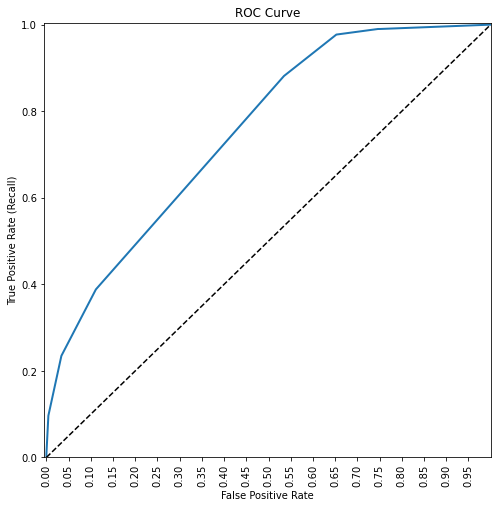

In [52]:
fpr, tpr, auc_thresholds = roc_curve(y_test, ypred)
plot_roc_curve(fpr, tpr)
print("ROC-AUC:", auc(fpr, tpr))

## Just Cap Data

In [6]:
cap_data = data[['class','cap-shape','cap-surface','cap-color']]
X = pd.get_dummies(cap_data, prefix_sep = '', 
                   columns = cap_data.columns.drop('class')).drop(['class'], 
                                                                  axis = 1)
y = np.where(cap_data["class"] == "e", 0, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, 
                                                    random_state = 1)

### Decision Tree - best

In [30]:
param_grid = {'max_depth': range(5, 20),
              'max_leaf_nodes': range(10, 50)}
skf = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 1), param_grid, 
                           scoring = ['precision', 'accuracy', 'recall'], 
                           refit = "recall", 
                           cv = skf, n_jobs = -1, verbose = True)
grid_search.fit(X_train, y_train)
print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    6.0s


Best params for recall
{'max_depth': 5, 'max_leaf_nodes': 10}


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   12.4s finished


In [24]:
model = DecisionTreeClassifier(random_state = 1, max_depth = 5, 
                               max_leaf_nodes = 10).fit(X_train, y_train)

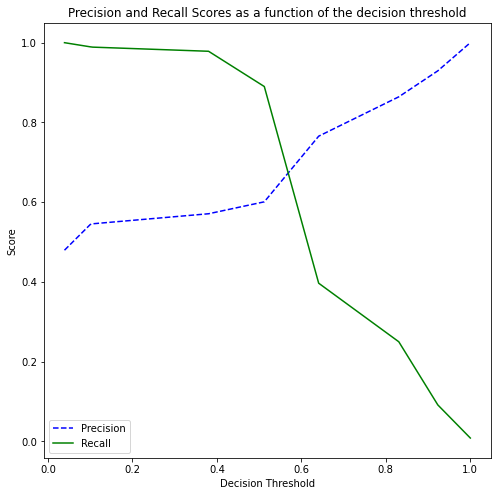

In [25]:
ypred = model.predict_proba(X_train)[:, 1]
p, r, thresholds = precision_recall_curve(y_train, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

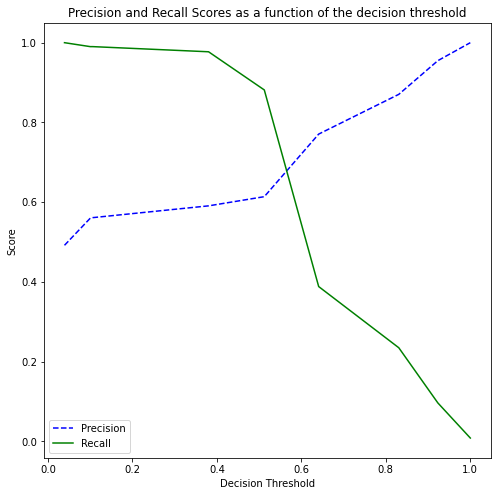

In [26]:
ypred = model.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [27]:
print(confusion_matrix_data(X_train, y_train, model))

Accuracy =  66.48906852838508
FNR =  11.0
Precision =  60.072689511941846
Recall =  89.0
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1305.0       1538.0
Actual 1        286.0       2314.0
 


In [28]:
print(confusion_matrix_data(X_test, y_test, model))

Accuracy =  66.952629615815
FNR =  11.854103343465045
Precision =  61.37566137566137
Recall =  88.14589665653496
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        635.0        730.0
Actual 1        156.0       1160.0
 


ROC-AUC: 0.7521919569791911


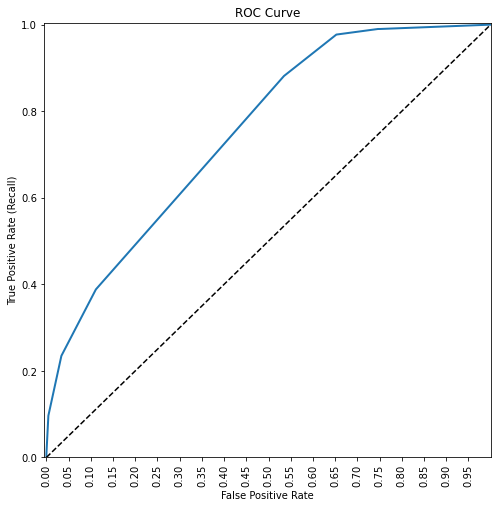

In [29]:
fpr, tpr, auc_thresholds = roc_curve(y_test, ypred)
plot_roc_curve(fpr, tpr)
print("ROC-AUC:", auc(fpr, tpr))

### Random Forest maximizing recall (worse than decision tree)

In [19]:
params = {'n_estimators': [500],
          'max_features': range(1,3),
          'max_depth': [2,4,6,8,10],
          'min_samples_leaf': [1,2,3,4,5]
         }
param_list=list(it.product(*(params[Name] for Name in list(params.keys()))))
recall = [0]*len(param_list)
fnr = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestClassifier(random_state=1,oob_score=True,verbose=False,
                                   n_estimators= pr[0],
                                   max_features=pr[1], 
                                   max_depth=pr[2],
                                   min_samples_leaf=pr[3],
                                   n_jobs=-1).fit(X_train,y_train)
    oob_pred = model.oob_decision_function_[:,1]
    bins=np.array([0,0.5,1])
    cm = np.histogram2d(y_train, oob_pred, bins=bins)[0]
    recall[i] = 100*(cm[1,1])/(cm[1,0]+cm[1,1])
    fnr[i] = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    i=i+1
print("max recall = ", np.max(recall))
print("params= ", param_list[np.argmax(recall)])

max recall =  65.5
params=  (500, 1, 8, 1)


In [20]:
model = RandomForestClassifier(random_state=1,oob_score=True,verbose=False,
                               n_estimators=500,
                               max_features=1, 
                               max_depth=8,
                               min_samples_leaf=1,
                               n_jobs=-1).fit(X_train,y_train)

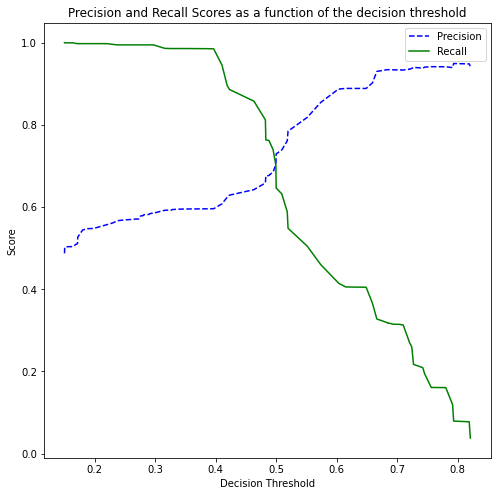

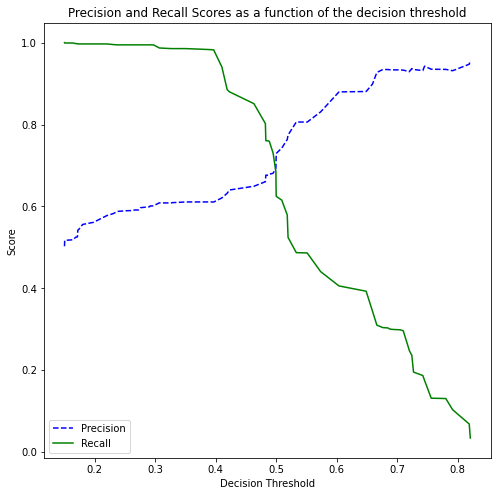

In [22]:
ypred = model.predict_proba(X_train)[:, 1]
p, r, thresholds = precision_recall_curve(y_train, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)
ypred = model.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [23]:
print(confusion_matrix_data(X_train, y_train, model))
print(confusion_matrix_data(X_test, y_test, model))

Accuracy =  71.65166268601874
FNR =  35.38461538461539
Precision =  72.94832826747721
Recall =  64.61538461538461
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       2220.0        623.0
Actual 1        920.0       1680.0
 
Accuracy =  70.19768743006341
FNR =  37.537993920972646
Precision =  72.93700088731144
Recall =  62.462006079027354
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1060.0        305.0
Actual 1        494.0        822.0
 


### AdaBoost - similar to Decision Tree

In [31]:
model = AdaBoostClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=1),
                          DecisionTreeClassifier(max_depth=2),
                          DecisionTreeClassifier(max_depth=3),
                          DecisionTreeClassifier(max_depth=4)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                           scoring=['recall','accuracy'],refit='recall')
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.888077 using {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.0001, 'n_estimators': 500}


In [32]:
model = AdaBoostClassifier(random_state=1,
                           base_estimator =DecisionTreeClassifier(max_depth=3),
                           learning_rate=0.0001,
                           n_estimators=500).fit(X_train,y_train)

In [33]:
print(confusion_matrix_data(X_train, y_train, model))
print(confusion_matrix_data(X_test, y_test, model))

Accuracy =  65.71743523792027
FNR =  11.192307692307692
Precision =  59.449021627188465
Recall =  88.8076923076923
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1268.0       1575.0
Actual 1        291.0       2309.0
 
Accuracy =  66.50503543453935
FNR =  11.930091185410335
Precision =  61.0
Recall =  88.06990881458967
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        624.0        741.0
Actual 1        157.0       1159.0
 


### Gradient Boosting - similar accuracy, worse FNR, recall than AdaBoost

In [36]:
model = GradientBoostingClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['max_depth'] = [1,2,3,4,5]
grid['subsample'] = [0.5,1.0]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                           scoring=['recall','accuracy'],refit='recall')
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.838846 using {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 10, 'subsample': 1.0}


In [38]:
model = GradientBoostingClassifier(random_state=1,
                                   learning_rate=0.1,
                                   max_depth=2,
                                   n_estimators=10,
                                   subsample = 1.0).fit(X_train,y_train)

In [39]:
print(confusion_matrix_data(X_train, y_train, model))
print(confusion_matrix_data(X_test, y_test, model))

Accuracy =  67.02186294322983
FNR =  18.423076923076923
Precision =  61.710794297352344
Recall =  81.57692307692308
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1527.0       1316.0
Actual 1        479.0       2121.0
 
Accuracy =  66.46773591943305
FNR =  20.288753799392097
Precision =  62.40333135038667
Recall =  79.7112462006079
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        733.0        632.0
Actual 1        267.0       1049.0
 


### XGBoost - very good FNR and decent recall - BEST Cap Data Model

In [42]:
param_grid = {'n_estimators':[25,100,500],
              'max_depth': [6,7,8],
              'learning_rate': [0.01,0.1,0.2],
              'gamma': [0.1,0.25,0.5],
              'reg_lambda':[0,0.01,0.001],
              'scale_pos_weight':[1.25,1.5,1.75]
             }
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
xgb_estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                              random_state=1,
                              use_label_encoder=False)
optimal_params = GridSearchCV(estimator=xgb_estimator,
                              param_grid = param_grid,
                              scoring = ['accuracy','recall'],
                              refit = 'recall',
                              verbose = 1, n_jobs=-1, cv = cv)
optimal_params.fit(X_train,y_train)
print(optimal_params.best_params_,optimal_params.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 69.5min


{'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 25, 'reg_lambda': 0, 'scale_pos_weight': 1.75} 0.9838461538461539


[Parallel(n_jobs=-1)]: Done 3645 out of 3645 | elapsed: 94.5min finished


In [57]:
model = xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,
                  gamma=0.1,learning_rate = 0.01,max_depth=6,
                  n_estimators = 25,reg_lambda = 0.01,
                  scale_pos_weight=1.75,use_label_encoder=False)
model.fit(X_train,y_train,eval_metric='error')

/Users/gxliu1/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=25, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=0.01, ...)

In [58]:
print(confusion_matrix_data(X_train, y_train, model))

Accuracy =  65.66231857431563
FNR =  1.7692307692307692
Precision =  58.35046835732237
Recall =  98.23076923076923
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1020.0       1823.0
Actual 1         46.0       2554.0
 


In [59]:
print(confusion_matrix_data(X_test, y_test, model))

Accuracy =  67.36292428198433
FNR =  1.6717325227963526
Precision =  60.27014438751747
Recall =  98.32826747720365
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        512.0        853.0
Actual 1         22.0       1294.0
 


### Ensembling

In [7]:
# Decision Tree
tree_model = DecisionTreeClassifier(random_state = 1, max_depth = 5, 
                                    max_leaf_nodes = 10).fit(X_train, y_train)
# Random Forest
forest_model = RandomForestClassifier(random_state=1,oob_score=True,
                                      verbose=False,
                                      n_estimators=500,
                                      max_features=1, 
                                      max_depth=8,
                                      min_samples_leaf=1,
                                      n_jobs=-1).fit(X_train,y_train)

# AdaBoost
ada_model = AdaBoostClassifier(random_state=1,
                           base_estimator =DecisionTreeClassifier(max_depth=3),
                           learning_rate=0.0001,
                           n_estimators=500).fit(X_train,y_train)

# Gradient Boosting
grad_model = GradientBoostingClassifier(random_state=1,
                                   learning_rate=0.1,
                                   max_depth=2,
                                   n_estimators=10,
                                   subsample = 1.0).fit(X_train,y_train)

# XGBoost
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,
                  gamma=0.1,learning_rate = 0.01,max_depth=6,
                  n_estimators = 25,reg_lambda = 0.01,
                  scale_pos_weight=1.75,use_label_encoder=False)

In [14]:
def confusion_matrix_data_ensembling(data,actual_values,model,cutoff=0.5):
    pred_values = model.predict(data)
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    recall = 100 - fnr 
    print("Accuracy = ", accuracy)
    print("FNR = ", fnr)
    print("Precision = ", precision)
    print("Recall = ", recall)
    print("Confusion matrix = \n", cm_df)
    return (" ")

#### Hard voting classifier

In [9]:
ensemble_model = VotingClassifier(estimators=[('tree', tree_model),
                                              ('rf', forest_model),
                                              ('ada',ada_model),
                                              ('gb',grad_model),
                                              ('xgb',xgb_model)])
ensemble_model.fit(X_train,y_train)

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(max_depth=5,
                                                     max_leaf_nodes=10,
                                                     random_state=1)),
                             ('rf',
                              RandomForestClassifier(max_depth=8,
                                                     max_features=1,
                                                     n_estimators=500,
                                                     n_jobs=-1, oob_score=True,
                                                     random_state=1,
                                                     verbose=False)),
                             ('ada',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                                 learning_rate=0.0001,
                                                 n_estimators=500...
              

In [15]:
print(confusion_matrix_data_ensembling(X_train, y_train, ensemble_model))

Accuracy =  66.74627962520668
FNR =  10.461538461538462
Precision =  60.217278841179514
Recall =  89.53846153846153
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1305.0       1538.0
Actual 1        272.0       2328.0
 


In [17]:
print(confusion_matrix_data_ensembling(X_test, y_test, ensemble_model))

Accuracy =  67.32562476687804
FNR =  11.094224924012158
Precision =  61.578947368421055
Recall =  88.90577507598785
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        635.0        730.0
Actual 1        146.0       1170.0
 


#### Stacking classifier w/ logistic regression as meta model

In [20]:
ensemble_model = StackingClassifier(estimators=[('tree', tree_model),
                                              ('rf', forest_model),
                                              ('ada',ada_model),
                                              ('gb',grad_model),
                                              ('xgb',xgb_model)],
                                    final_estimator=LogisticRegression(random_state=1,
                                                                       max_iter=10000),
                                    n_jobs=-1,
                                    cv =StratifiedKFold(n_splits=5,
                                                        shuffle=True,
                                                        random_state=1))
ensemble_model.fit(X_train,y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimators=[('tree',
                                DecisionTreeClassifier(max_depth=5,
                                                       max_leaf_nodes=10,
                                                       random_state=1)),
                               ('rf',
                                RandomForestClassifier(max_depth=8,
                                                       max_features=1,
                                                       n_estimators=500,
                                                       n_jobs=-1,
                                                       oob_score=True,
                                                       random_state=1,
                                                       verbose=False)),
                               ('ada',
                                AdaBoostClassifier(base_estimator=DecisionTree...
             

In [21]:
print(confusion_matrix_data_ensembling(X_train, y_train, ensemble_model))

Accuracy =  71.61491824361565
FNR =  33.11538461538461
Precision =  71.7705323978539
Recall =  66.88461538461539
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       2159.0        684.0
Actual 1        861.0       1739.0
 


In [22]:
print(confusion_matrix_data_ensembling(X_test, y_test, ensemble_model))

Accuracy =  69.75009324878776
FNR =  35.182370820668694
Precision =  71.02414654454621
Recall =  64.8176291793313
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1017.0        348.0
Actual 1        463.0        853.0
 


#### Stacking classifier w/ random forest as meta model

In [24]:
params = {'n_estimators': [500],
          'max_features': range(1,3),
          'max_depth': [2,4,6,8,10],
          'min_samples_leaf': [1,2,3,4,5]
         }
param_list=list(it.product(*(params[Name] for Name in list(params.keys()))))
oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = StackingClassifier(estimators=[('tree', tree_model),
                                              ('rf', forest_model),
                                              ('ada',ada_model),
                                              ('gb',grad_model),
                                              ('xgb',xgb_model)],
                               final_estimator=RandomForestClassifier(n_estimators=500, 
                                                                      max_features=1,
                                                                      random_state=1,
                                                                      oob_score=True),
                               n_jobs=-1,
                               cv =StratifiedKFold(n_splits=5,
                                                   shuffle=True,
                                                   random_state=1))
    model.fit(X_train,y_train)
    oob_score[i] = model.final_estimator_.oob_score_
    i=i+1
print("max oob score = ", np.max(oob_score))
print("params= ", param_list[np.argmax(oob_score)])

max oob score =  0.7014514054749219
params=  (500, 1, 2, 1)


In [25]:
ensemble_model = StackingClassifier(estimators=[('tree', tree_model),
                                              ('rf', forest_model),
                                              ('ada',ada_model),
                                              ('gb',grad_model),
                                              ('xgb',xgb_model)],
                                    final_estimator=RandomForestClassifier(n_estimators=500, 
                                                                           max_features=1,
                                                                           max_depth=2,
                                                                           min_samples_leaf=1,
                                                                           random_state=1,
                                                                           oob_score=True),
                                    n_jobs=-1,
                                    cv =StratifiedKFold(n_splits=5,
                                                        shuffle=True,
                                                        random_state=1))
ensemble_model.fit(X_train,y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimators=[('tree',
                                DecisionTreeClassifier(max_depth=5,
                                                       max_leaf_nodes=10,
                                                       random_state=1)),
                               ('rf',
                                RandomForestClassifier(max_depth=8,
                                                       max_features=1,
                                                       n_estimators=500,
                                                       n_jobs=-1,
                                                       oob_score=True,
                                                       random_state=1,
                                                       verbose=False)),
                               ('ada',
                                AdaBoostClassifier(base_estimator=DecisionTree...
             

In [26]:
print(confusion_matrix_data_ensembling(X_train, y_train, ensemble_model))

Accuracy =  68.95094616939188
FNR =  10.653846153846153
Precision =  62.17880085653105
Recall =  89.34615384615384
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1430.0       1413.0
Actual 1        277.0       2323.0
 


In [27]:
print(confusion_matrix_data_ensembling(X_test, y_test, ensemble_model))

Accuracy =  68.89220440134278
FNR =  11.474164133738602
Precision =  63.04112554112554
Recall =  88.5258358662614
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        682.0        683.0
Actual 1        151.0       1165.0
 


## Decision Tree with Predictors with Human Readable Names

In [117]:
readable_data = data.drop(columns = ['bruises','ring-number',
                                     'ring-type','spore-print-color'])
X = pd.get_dummies(readable_data, prefix_sep = '', 
                   columns = readable_data.columns.drop('class'))
X = X.drop(['class'], axis = 1)
y = np.where(readable_data["class"] == "e", 0, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, 
                                                    random_state = 1)

In [119]:
# Single Decision Tree
param_grid = {'max_depth': range(5, 20),
              'max_leaf_nodes': range(10, 50)}
skf = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 1), param_grid, 
                           scoring = ['precision', 'accuracy', 'recall'], 
                           refit = "recall", 
                           cv = skf, n_jobs = -1, verbose = True)
grid_search.fit(X_train, y_train)
print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 712 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1712 tasks      | elapsed:   20.4s


Best params for recall
{'max_depth': 9, 'max_leaf_nodes': 26}


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   36.4s finished


In [120]:
model = DecisionTreeClassifier(random_state = 1, max_depth = 9, 
                               max_leaf_nodes = 26).fit(X_train, y_train)

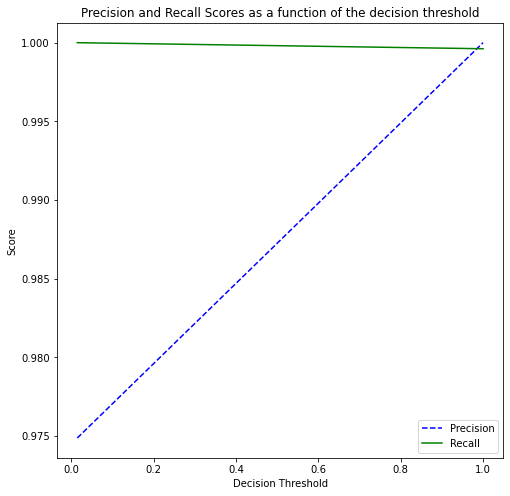

In [121]:
ypred = model.predict_proba(X_train)[:, 1]
p, r, thresholds = precision_recall_curve(y_train, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

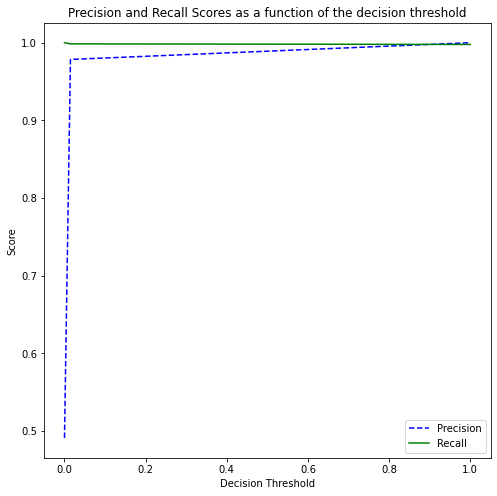

In [122]:
ypred = model.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [123]:
print(confusion_matrix_data(X_train, y_train, model))

Accuracy =  99.98162777879845
FNR =  0.038461538461538464
Precision =  100.0
Recall =  99.96153846153847
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       2843.0          0.0
Actual 1          1.0       2599.0
 


In [124]:
print(confusion_matrix_data(X_test, y_test, model))

Accuracy =  99.88810145468109
FNR =  0.22796352583586627
Precision =  100.0
Recall =  99.77203647416414
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       1365.0          0.0
Actual 1          3.0       1313.0
 


ROC-AUC: 0.9992159056748722


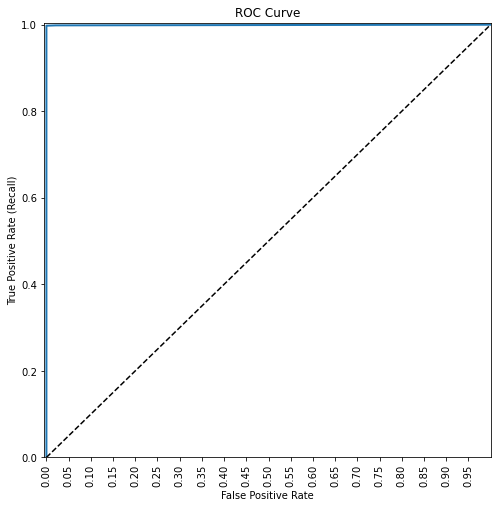

In [125]:
fpr, tpr, auc_thresholds = roc_curve(y_test, ypred)
plot_roc_curve(fpr, tpr)
print("ROC-AUC:", auc(fpr, tpr))